First import all neccessary modules

In [1]:
from datetime import datetime
from preprocess import Preprocessor
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense
from keras.metrics import Accuracy, Precision, Recall
from keras.callbacks import EarlyStopping
from sklearn.metrics import classification_report, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from message_encoder import *
from keras.optimizers import Adam, RMSprop, SGD, Nadam

Next we define all hyperparameters for the Training of the LSTM module. 

In [2]:
# hyper parameters
# preprocessing
log_files = [i for i in range(745, 760)]            # list of ints representing the numbers of log files to use
logs_per_class = 100                                # How many datapoints per class should be collected if available
window_size = 20                                    # how many log messages to be considered in a single data point from sliding window
encoding_output_size = 16                           # size to be passed to the message_encoder, note that this is not neccessairily the shape of the output
message_encoder = TextVectorizationEncoder(10000, True, encoding_output_size) # the message_encoder to be used. Can be TextVectorizationEncoder (uses keras.layers.TextVectorizer), BERTEncoder (only uses the BERT tokenizer) or BERTEmbeddingEncoder (also uses the BERT model)
test_ratio = 0.2                                    # percantage of the collected data that should be used for testing rather than training
extended_datetime_features = False                  # bool, whether the preprocessing should use a multitude of normalized features extracted from the date 
# lstm architecture
lstm_layers = 1                                     # int, how many lstm layers to use
lstm_units_per_layer = 50                           # int, how many lstm units per layer to use
dropout = 0.0                                       # float, which dropout value to use, 0.0 is equivalent to not using any dropout
recurrent_dropout = 0.0                             # float, same as with regular dropout
# training
epochs = 1000                                       # number of iterations to train
batch_size = 32                                     # int, number of samples processed before updating the model weights.
early_stopping_monitor = "val_loss"                 # what value to monitor for early_stopping. can be 'loss', 'val_loss', 'accuracy', 'val_accuracy', 'precision', 'val_precision', 'recall', 'val_recall', 'f1_score', 'val_f1_score'
early_stopping_patience = 10                        # int, number of epochs to wait after no improvement, if this is greater than epochs, EarlyStopping will not apply
early_stopping_restore_best = True                  # bool, if true keeps the best weights, not the final ones.
validation_split = 0.1
learning_rate = 0.001                               # float to specify learning rate of the optimizer
optimizer = Adam(learning_rate=learning_rate)       # optimizer, can be one of Adam, RMSprop, SGD (can have momentum parameter), Nadam


Next we load logs and preprocess the data. 

In [3]:
# preprocessing
pp = Preprocessor(log_files, 
                  message_encoder, 
                  logs_per_class=logs_per_class, 
                  window_size=window_size, 
                  extended_datetime_features=extended_datetime_features, 
                  volatile=True)
train_data, test_data = pp.stratified_split(test_ratio=test_ratio)
X_train, y_train = zip(*train_data)
X_test, y_test = zip(*test_data)

X_train = np.array(X_train)
y_train = np.array(y_train)
X_test = np.array(X_test)
y_test = np.array(y_test)

Current log file: C:/Users/Askion/Documents/agmge/log-classification/data/CCI/CCLog-backup.745.log


parsing log file:   0%|          | 0/811279 [00:00<?, ?it/s]

annotating events:   0%|          | 0/807974 [00:00<?, ?it/s]

Current State counts:
  - 0 : 100
  - 3 : 100
  - 2 : 14
  - 1 : 4
Current log file: C:/Users/Askion/Documents/agmge/log-classification/data/CCI/CCLog-backup.746.log


parsing log file:   0%|          | 0/322863 [00:00<?, ?it/s]

annotating events:   0%|          | 0/314649 [00:00<?, ?it/s]

Current State counts:
  - 0 : 100
  - 3 : 100
  - 2 : 34
  - 1 : 10
Current log file: C:/Users/Askion/Documents/agmge/log-classification/data/CCI/CCLog-backup.747.log


parsing log file:   0%|          | 0/185821 [00:00<?, ?it/s]

annotating events:   0%|          | 0/178255 [00:00<?, ?it/s]

Current State counts:
  - 0 : 100
  - 3 : 100
  - 2 : 62
  - 1 : 10
Current log file: C:/Users/Askion/Documents/agmge/log-classification/data/CCI/CCLog-backup.748.log


parsing log file:   0%|          | 0/217424 [00:00<?, ?it/s]

annotating events:   0%|          | 0/207352 [00:00<?, ?it/s]

Current State counts:
  - 0 : 100
  - 3 : 100
  - 2 : 100
  - 1 : 19
Current log file: C:/Users/Askion/Documents/agmge/log-classification/data/CCI/CCLog-backup.749.log


parsing log file:   0%|          | 0/86349 [00:00<?, ?it/s]

annotating events:   0%|          | 0/76720 [00:00<?, ?it/s]

Current State counts:
  - 0 : 100
  - 3 : 100
  - 2 : 100
  - 1 : 37
Current log file: C:/Users/Askion/Documents/agmge/log-classification/data/CCI/CCLog-backup.750.log


parsing log file:   0%|          | 0/104128 [00:00<?, ?it/s]

annotating events:   0%|          | 0/103928 [00:00<?, ?it/s]

Current State counts:
  - 0 : 100
  - 3 : 100
  - 2 : 100
  - 1 : 55
Current log file: C:/Users/Askion/Documents/agmge/log-classification/data/CCI/CCLog-backup.751.log


parsing log file:   0%|          | 0/103334 [00:00<?, ?it/s]

annotating events:   0%|          | 0/103134 [00:00<?, ?it/s]

Current State counts:
  - 0 : 100
  - 3 : 100
  - 2 : 100
  - 1 : 73
Current log file: C:/Users/Askion/Documents/agmge/log-classification/data/CCI/CCLog-backup.752.log


parsing log file:   0%|          | 0/102980 [00:00<?, ?it/s]

annotating events:   0%|          | 0/102703 [00:00<?, ?it/s]

Current State counts:
  - 0 : 100
  - 3 : 100
  - 2 : 100
  - 1 : 91
Current log file: C:/Users/Askion/Documents/agmge/log-classification/data/CCI/CCLog-backup.753.log


parsing log file:   0%|          | 0/301697 [00:00<?, ?it/s]

annotating events:   0%|          | 0/253791 [00:00<?, ?it/s]

Current State counts:
  - 0 : 100
  - 3 : 100
  - 2 : 100
  - 1 : 100
All states have the desired log count


Define the model architecture for the LSTM, then train the LSTM model. 

In [4]:
# lstm architecture
model = Sequential()
input_shape = pp.get_shape()
# First LSTM layer
if lstm_layers > 1:
    model.add(LSTM(lstm_units_per_layer, input_shape=input_shape, return_sequences=True))
else:
    model.add(LSTM(lstm_units_per_layer, input_shape=input_shape))  # single layer, no sequences returned
# Intermediate LSTM layers (if any)
for i in range(lstm_layers - 2):
    model.add(LSTM(lstm_units_per_layer, return_sequences=True))
# Last LSTM layer (no return_sequences, output fed into Dense)
if lstm_layers > 1:
    model.add(LSTM(lstm_units_per_layer))
# Dense Layer
num_classes = len(set(y_train))
model.add(Dense(num_classes, activation='softmax'))
# compile the model
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])


# train the model
early_stopping = EarlyStopping(monitor=early_stopping_monitor, 
                               patience=early_stopping_patience, 
                               restore_best_weights=early_stopping_restore_best)
model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation_split, callbacks=[early_stopping])


Epoch 1/1000


c:\Users\Askion\Documents\agmge\log-classification\venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


9/9 ━━━━━━━━━━━━━━━━━━━━ 2s 50ms/step - accuracy: 0.3689 - loss: 1.5960 - val_accuracy: 0.1875 - val_loss: 1.7791
Epoch 2/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.3921 - loss: 1.4858 - val_accuracy: 0.2812 - val_loss: 1.6742
Epoch 3/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.4284 - loss: 1.4116 - val_accuracy: 0.2812 - val_loss: 1.5861
Epoch 4/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4023 - loss: 1.3562 - val_accuracy: 0.2812 - val_loss: 1.5115
Epoch 5/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4229 - loss: 1.2772 - val_accuracy: 0.3125 - val_loss: 1.3947
Epoch 6/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.4638 - loss: 1.2230 - val_accuracy: 0.3125 - val_loss: 1.3227
Epoch 7/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step - accuracy: 0.5094 - loss: 1.1610 - val_accuracy: 0.3438 - val_loss: 1.2502
Epoch 8/1000
9/9 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step - accuracy: 0.5171 - loss: 1.1154 - val_accuracy: 0.3438 - val_loss: 1.19

Optionally save the weights of the model

In [5]:
filename = f"lstm_{lstm_layers}x{lstm_units_per_layer}_drop{dropout}_rec{recurrent_dropout}_enc{message_encoder.__class__.__name__.lower()}_{logs_per_class}logs_win{window_size}_lr{learning_rate}_bs{batch_size}_ep{epochs}_{early_stopping_monitor}_{datetime.now().strftime('%Y%m%d_%H%M%S')}"
model.save(f"{filename}.h5")

Evaluate model and print scores

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 50)             │        14,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4)              │           204 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 43,214 (168.81 KB)

 Trainable params: 14,404 (56.27 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 28,810 (112.54 KB)

loss: 0.4246
compile_metrics: 0.7625
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 124ms/step

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        20
           1       0.54      0.65      0.59        20
           2       0.53      0.40      0.46        20
           3       0.95      1.00      0.98        20

    accuracy                           0.76        80
   macro avg       0.76      0.76      0.76        80
weighted avg       0.76      0.76      0.76        80

F1 Score (weighted): 0.7559


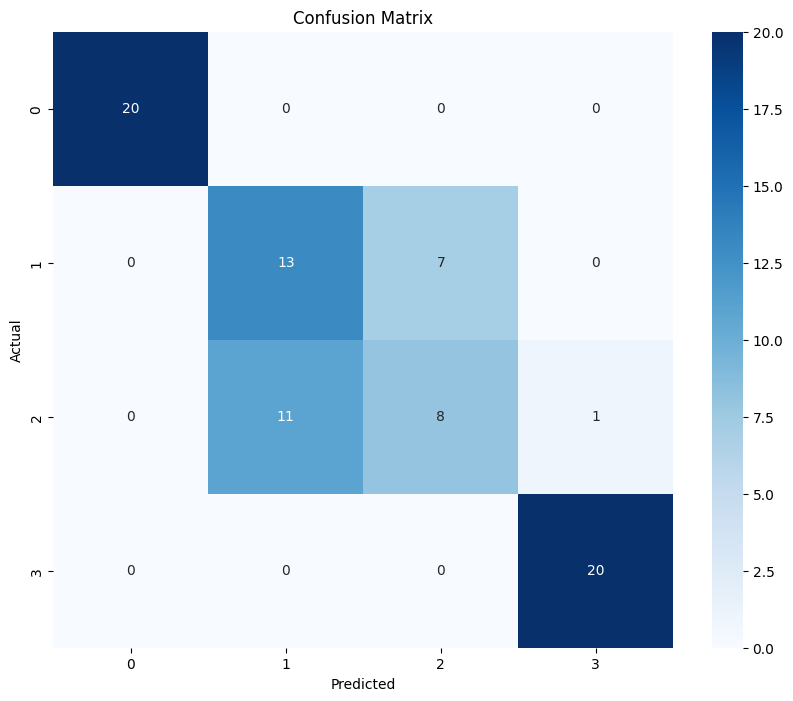

In [6]:
# Summary of the model
model.summary()

# Evaluate the model on test data
results = model.evaluate(X_test, y_test, verbose=0)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

# Predictions
predictions = model.predict(X_test)
y_pred = np.argmax(predictions, axis=1)

# Classification report and F1 score
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1 Score (weighted): {f1:.4f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.savefig(f"{filename}.png")
plt.show()


Save the confusion matrix